In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import pandas.io.sql as psql
import numpy as np
import matplotlib.pyplot as plt
import itertools
import matplotlib.dates as mdates
import datetime as dt
from datetime import datetime
import time
from datetime import timedelta
from collections import defaultdict, Counter
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from fbprophet import Prophet 
from itertools import chain, combinations
import math
import matplotlib.ticker as ticker

In [2]:
from ordergeniefunctions import *

In [3]:
%matplotlib inline

##need to change to user input for company id from commandline in script 
company_id = 94

In [4]:
all_orders_over_time = pd.read_csv("new_updated_all_orders.csv")
all_orders_over_time['order_date'] = pd.to_datetime(all_orders_over_time['order_date'], errors='coerce').dt.date
all_orders_over_time["variant_id"] = all_orders_over_time["variant_id"].astype(int)
description_dict = dict(zip(all_orders_over_time.variant_id,all_orders_over_time.prod_description))
print (all_orders_over_time.shape)
all_orders_over_time.head(2)


(210197, 10)


,actual_order_id,quantity,price,prod_description,total_for_item,variant_id,sku,company_id,total_for_order,order_date
0,27852,1.0,5.19,"Hummus, 2oz",5.19,4336,Sabra-Hummus-2oz-Original-Case,118,534.57,2018-01-10
1,27852,6.0,0.75,Red Apples,4.50,4886,fruit-organic-red-apples-fuji-single,118,534.57,2018-01-10


In [5]:
##get date range
earliestDate =  all_orders_over_time["order_date"].min()
xmin = earliestDate
xmax = dt.date.today()
xminaxis = xmin - timedelta(days=5)
xmaxaxis = xmax + timedelta(days=12)

In [6]:
dfcompany = all_orders_over_time[all_orders_over_time["company_id"] == company_id]
dfsize = dfcompany.shape[0]
if ( dfsize== 0):
	print ("company doesn't exist")
	exit 

In [7]:
all_order_df = get_all_orders_by_company(all_orders_over_time, company_id)
print ("All orders by company")
print (all_order_df.head(3))

All orders by company
   actual_order_id  quantity  price   prod_description  total_for_item  \
0            27801       8.0   3.89   Raspberries, 6oz           31.12   
1            27801       1.0   4.81            Tea Box            4.81   
2            27801       1.0   2.59  Rice Cakes, 8.5oz            2.59   

   variant_id                                             sku  company_id  \
0         167                    fruit-raspberries-6oz-single          94   
1        2626                Numi-Tea-GingerLemon-16ct-Single          94   
2        1610  Lundberg-RiceCake-SaltFreeBrownRice-8oz-Single          94   

   total_for_order  order_date  
0           560.47  2018-01-10  
1           560.47  2018-01-10  
2           560.47  2018-01-10  


In [8]:
last_order_df = get_last_order_by_company(all_orders_over_time, company_id)
last_order_date = get_last_order_date(all_orders_over_time, company_id)
print ("last order date")
print (last_order_date)

last order date
2018-01-10


In [9]:
list_items_in_all_order = get_all_order_items(all_orders_over_time, company_id)
print ("list_items_in_all_order")
print (list_items_in_all_order)

list_items_in_all_order
[ 167 2626 1610  459 3132 4083 3780 2624 1825 4034  241 5211 2943 4578 2188
 5626 4075 3902 6854 2286 4423 2859 3778 4686 1139 6803  494 4183 1697 1855
 5686   37 2708 4266 3246 1707  173 3983 6322 1730 1495 1679  669 1375 1514
  170 4886 3979 1978  715  161 4210 6060 2628 2967 4089 4336  994 4250 2711
  249 1246 1685 2811 1733  713 4319  266 2345 4074  654 1507 4992 2304 1520
 5018 5017 1974 1148 3243 4197 1756 1771  336 4045 6163 6104 3350  456 4850
 4687 2893 1299 1338  287 3242 1498 4192 4073 2895 4300 6470 1927 1704 1747
 4188 1710 5698 1724 1727 4409  666 4072 2505 1700 6111 4508 4481 3548 2735
 2979 4235 6904  698 3973 4287  310 1136 3907 3905 1889 6110 2710 4071 5237
 2756 1736 3985 1934 5019  152 4479 5701 5728 4534 2747 5092 3134 5695 4069
  284 1010 4407 5532 1868 2191 4843 1823 5670 4945 1745  663 4370 6806  328
 4724 5014 4327 2557 5809 4476 4037 4039 4993 2737  584  176 5209 4894 3800
 4403 3561 5024  168 1843  919 1750 1940 2235 3799 3072 3026 183

In [10]:
list_items_in_last_order = get_last_order_items(all_orders_over_time, company_id)
print ("list_items_in_last_order")
print (list_items_in_last_order)

list_items_in_last_order
[ 167 2626 1610  459 3132 4083 3780 2624 1825 4034  241 5211 2943 4578 2188
 5626 4075 3902 6854 2286 4423 2859 3778 4686 1139 6803  494 4183 1697 1855
 5686   37 2708 4266 3246 1707  173 3983 6322 1730 1495 1679  669 1375 1514
  170 4886 3979 1978  715  161 4210 6060 2628 2967 4089 4336  994 4250 2711
  249 1246 1685 2811 1733  713 4319  266]


In [11]:
list_prev_purch_items_not_in_last_order = get_non_last_order_items(all_orders_over_time, company_id)
print ("list_prev_purch_items_not_in_last_order")
list_prev_purch_items_not_in_last_order

list_prev_purch_items_not_in_last_order


[3072,
 3073,
 6163,
 38,
 3134,
 4184,
 5209,
 4185,
 4188,
 4189,
 4190,
 4187,
 4192,
 4186,
 4191,
 4197,
 1133,
 1134,
 1136,
 1137,
 5237,
 1148,
 4220,
 4235,
 2189,
 2191,
 2192,
 152,
 153,
 4251,
 168,
 3243,
 3242,
 176,
 3247,
 171,
 174,
 177,
 3249,
 2233,
 2235,
 4287,
 4300,
 4301,
 6350,
 219,
 4327,
 1270,
 2304,
 4352,
 1285,
 6412,
 2317,
 2319,
 4370,
 1299,
 5397,
 3350,
 3351,
 3353,
 284,
 287,
 2345,
 297,
 4403,
 4404,
 310,
 4407,
 4409,
 1338,
 3388,
 4416,
 1347,
 6470,
 328,
 336,
 3438,
 2427,
 4476,
 4479,
 384,
 4481,
 4505,
 4508,
 5532,
 5533,
 4509,
 4523,
 4534,
 3511,
 456,
 2505,
 1498,
 3548,
 3549,
 1504,
 480,
 1507,
 3561,
 2541,
 1520,
 502,
 2557,
 5670,
 5694,
 5695,
 5698,
 5701,
 583,
 584,
 6729,
 4687,
 5728,
 4710,
 4711,
 1647,
 4724,
 4744,
 654,
 4750,
 657,
 2710,
 663,
 6806,
 666,
 1688,
 660,
 672,
 1698,
 1700,
 1701,
 1704,
 3752,
 2732,
 1710,
 2735,
 5809,
 2737,
 5811,
 1721,
 698,
 2747,
 1724,
 1725,
 1722,
 1727,
 1728,


In [12]:
all_minus_last_df = get_all_except_last(all_order_df, company_id)
all_minus_last_df.head(3)

,actual_order_id,quantity,price,prod_description,total_for_item,variant_id,sku,company_id,total_for_order,order_date
68,27648,1.0,4.81,Tea Box,4.81,2628,Numi-Tea-ChamomileLemon-18ct-Single,94,734.33,2018-01-09
69,27648,1.0,26.93,"Raw Almonds, 2.5lb",26.93,6163,OMGBulk-OrgRawAlmonds-2-5lb-Case,94,734.33,2018-01-09
70,27648,1.0,4.93,"Cinnamon Toast Crunch Cereal, 12.2 oz",4.93,4578,CinnamonToastCrunch-12oz-Single,94,734.33,2018-01-09


In [13]:
basket = (all_order_df.sort_values('order_date', ascending = True).groupby(['order_date', "variant_id"])['quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('order_date'))
basket = basket[(basket.T != 0).any()]
basket = basket.loc[:, (basket != 0).any(axis=0)]
basket.index = pd.to_datetime(basket.index)
basket = basket.reindex_axis(basket.sum().sort_values( ascending=False).index, axis=1)

###limit basket size for demo purposes 
basket = basket.iloc[:,0:6]

print ("Quantity of Items over Time")
print (basket.tail(5)) 

Quantity of Items over Time
variant_id  161   170   2188  4319  4886  6322
order_date                                    
2018-01-04  10.0   8.0  30.0   6.0   4.0   6.0
2018-01-07  15.0   8.0  30.0   6.0   6.0   6.0
2018-01-08  15.0  10.0  30.0   6.0   6.0   6.0
2018-01-09  15.0  10.0   0.0   6.0   6.0   6.0
2018-01-10  15.0  10.0  30.0   6.0   6.0   6.0


In [14]:
def getProphet(df):
    #ProphetModel 
    m = Prophet()
    m.fit(df);
    #add today to dataframe
    future_df = df.filter(["ds"], axis=1)
    today_df = pd.DataFrame(data = [dt.date.today()], columns = ["ds"])
    future = future_df.append(today_df, ignore_index=True)
    forecast = m.predict(future)
    forecast["yhat"] = forecast["yhat"].astype(int)
    return forecast

def getProphetPredictionGraph(var_id, label, ax, forecast_df, observedsize, xminaxis, xmaxaxis, ymin, ymax):
    ##forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    x = forecast_df["ds"]
    x = pd.to_datetime(x)
    y = forecast_df["yhat"]
    xobs = x[0:observedsize]
    yobs = y[0:observedsize]
    xpred =  x[observedsize-1:]
    ypred =  y[observedsize-1:]
    xpredp =  x[observedsize:]
    ypredp =  y[observedsize:]
    plt.xticks(rotation=80, ha="right")
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    ax.plot(xobs,yobs, linestyle="-", marker = "o", markerfacecolor="None", markeredgecolor="blue", markeredgewidth=1, label="Observed")
    ax.plot(xpred, ypred, linestyle="--", color = "red", label="_nolegend_")
    ax.plot(xpredp,ypredp, linestyle="--", markersize=8,  marker = "o", color = "red", label='Predicted')
    p = ax.plot(xpredp,ypredp,  marker = "o", markersize=14, markerfacecolor="None", markeredgecolor="red", markeredgewidth=1,color = "red", label='_nolegend_')
    ax.set_title(label)
    ax.set_autoscale_on(False)
    plt.setp( ax.xaxis.get_majorticklabels(), rotation=80 )
    ax.set_xlim(xmin = xmin, xmax = xmax)
    yint = range(ymin, math.ceil(ymax)+3)
    ax.yaxis.set_ticks(yint)
    ax.legend(loc=2)
    return 

In [15]:
trim_basket = [] 
df_trim = {}
var_quantit = {}
ymin = 0
ymax = 0

for var_id in basket:
    print ("sku: ", var_id)
    s1 = pd.Series(basket.index, name = "ds").reset_index(drop = True)
    s2 = pd.Series(basket[var_id], name = "y").reset_index(drop = True)

    df = pd.concat([s1, s2], axis=1)
    df["ds"] = pd.to_datetime(df["ds"])
    
    forecast = getProphet(df)
    forecast_quant = forecast["yhat"].iloc[-1]
    #print (forecast_quantity)
    if (forecast_quant > 0):
        trim_basket.append(var_id)
        df_trim[var_id] = forecast
        var_quantit[var_id] = forecast_quant
        if (ymax < df_trim[var_id]['yhat'].max()):
            ymax = df_trim[var_id]['yhat'].max()

sku:  161
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
sku:  170
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
sku:  2188
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
sku:  4319
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
sku:  4886
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
sku:  6322
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [16]:
trim_basket

[161, 170, 2188, 4319, 4886, 6322]

In [17]:
filteron = ["variant_id", "prod_description", "quantity"]
#print "Recommended order: "
filtered_all_order = all_order_df.filter(items = filteron)
new_order = filtered_all_order[filtered_all_order['variant_id'].isin(trim_basket)]
filtered_new_order = new_order.drop_duplicates(subset='variant_id', keep='first', inplace=False).reset_index(drop=True)
for var_id in trim_basket:
    filtered_new_order['quantity'][filtered_new_order.variant_id == var_id] = int(var_quantit[var_id])

# forecasted order

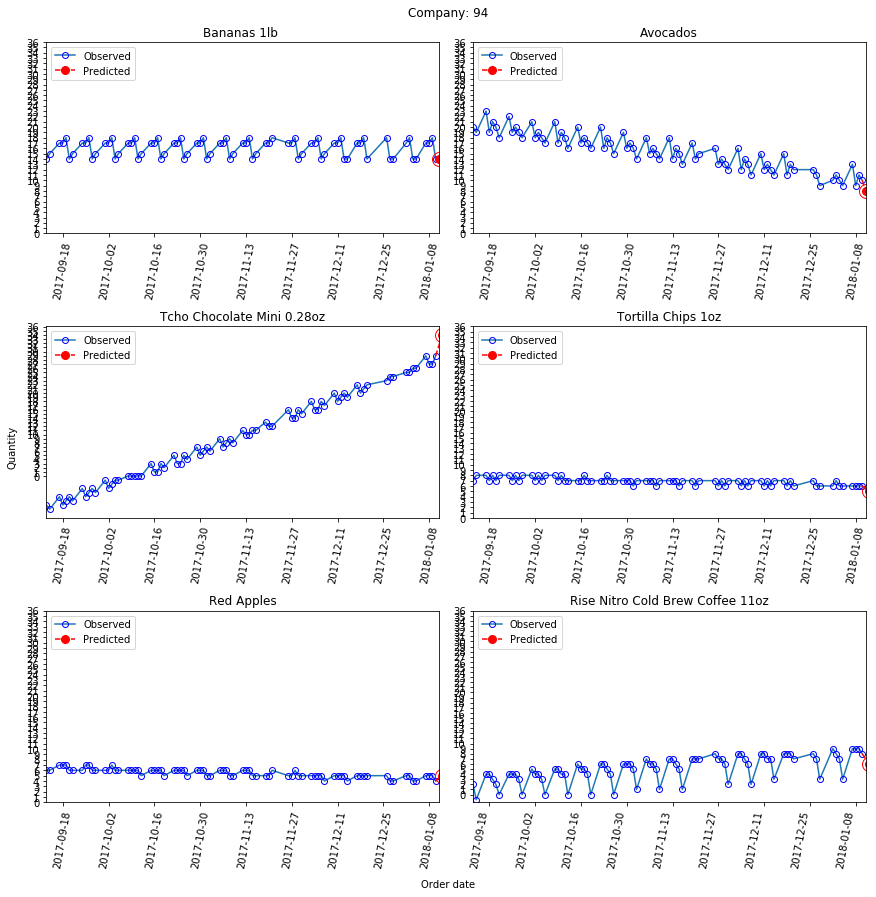

In [18]:
### plot all items for particular company
numItems = len(trim_basket)
numCol = 2
numRow = numItems // numCol + (numItems % numCol > 0)
reminder = numItems%numCol
height = 4 * numRow

#fig, axes = plt.subplots(nrows=numRow, ncols=numCol, sharex=True, sharey=True, figsize=(12, height))
fig, axes = plt.subplots(nrows=numRow, ncols=numCol, figsize=(12, height))
#axes_list = [item for sublist in axes for item in sublist] 

axes_list = axes.tolist()

counter = 0
for var_id in trim_basket:
    label =  description_dict[var_id]
    forecast_df = df_trim[var_id]   
    forecast_df["ds"] = pd.to_datetime(forecast_df["ds"])
    #predictionsize = forecast_df.shape[0]-df.shape[0]
    observedsize = forecast_df.shape[0] - 1
    ax = fig.axes[counter]
    getProphetPredictionGraph(var_id, label, ax, forecast_df, observedsize, xminaxis, xmaxaxis, ymin, ymax)
    counter = counter + 1

while counter < numItems:
    ax = (fig.axes[counter])
    ax.plot(0,0)
    counter = counter +1
    #ax.tick_params(labelbottom='off')  

fig.text(0.5, -0.01, 'Order date', ha='center')
fig.text(-0.01, 0.5, 'Quantity', va='center', rotation='vertical')
plt.suptitle("Company: "+str(company_id), y=1.01)

fig.tight_layout()
fig.show()

In [19]:
recom_order_items = filtered_new_order["variant_id"]
#recom_order_items["variant_id"] = recom_order_items["variant_id"].astype(str)
recom_order_display = filtered_new_order.copy(deep = True).reset_index(drop=True)
recom_order_display["variant_id"] = recom_order_display["variant_id"].astype(int).astype(str)
recom_order_display.rename(columns = {"variant_id": "Product ID", "prod_description": "Product Description","quantity": "Quantity"}, inplace = True)

print (recom_order_display)

  Product ID                Product Description  Quantity
0       2188        Tcho Chocolate Mini, 0.28oz      34.0
1       6322  Rise Nitro Cold Brew Coffee, 11oz       6.0
2        170                           Avocados       8.0
3       4886                         Red Apples       5.0
4        161                      Bananas, 1lb       14.0
5       4319                Tortilla Chips, 1oz       5.0


# last order from company for reference

In [20]:
last_order_filtered = last_order_df.filter(items = filteron).reset_index(drop=True)
last_order_filtered["variant_id"] = last_order_filtered["variant_id"].astype(int).astype(str)
last_order_filtered.rename(columns = {"variant_id": "Product ID", "prod_description": "Product Description","quantity": "Quantity"}, inplace = True)
last_order_filtered.head()


,Product ID,Product Description,Quantity
0,167,"Raspberries, 6oz",8.0
1,2626,Tea Box,1.0
2,1610,"Rice Cakes, 8.5oz",1.0
3,459,"Tea, 16.9oz",1.0
4,3132,"Yogurt, 4oz",1.0


# frequently purchased items from company 

In [21]:
top_items = getTopFiveItemsNotInCurrentOrder(all_order_df, trim_basket).reset_index(drop=True)
top_items["variant_id"] = top_items["variant_id"].astype(int).astype(str)
top_items.rename(columns = {"variant_id": "Product ID", "prod_description": "Product Description","Avg_quantity": "Avg quantity"}, inplace = True)
print (top_items)

  Product ID Product Description  Avg quantity
0        167    Raspberries, 6oz             8
1       2626             Tea Box             1
2       1610   Rice Cakes, 8.5oz             1
3        459         Tea, 16.9oz             1
4       3132         Yogurt, 4oz             1


# Recommended items based on products frequently purchased together

In [22]:
list_items = recom_order_items.tolist()
boughtTogether = getCommonBoughtTogether(all_orders_over_time, list_items)
filteron = ["antecedants", "current_list", "consequents", "recommend_list"]
boughtTogetherPairs = boughtTogether.filter(items = filteron)
colnamesList = ["variant_id1", "prod_description1", "variant_id2", "prod_description2"]
boughtTogetherPairs.columns =  colnamesList

In [23]:
displayboughtTogetherPairs = boughtTogetherPairs.copy(deep=True)
for index, row in displayboughtTogetherPairs.iterrows():
    prod_list1 = (list(row["variant_id1"]))
    newlist = [int(l) for l in prod_list1]
    str1 = ",".join(str(x) for x in newlist)
    row["variant_id1"] = str1
    prod_list2 = (list(row["variant_id2"]))
    newlist = [int(l) for l in prod_list2]
    str1 = ",".join(str(x) for x in newlist)
    row["variant_id2"] = str1
    str1 = row["prod_description1"]
    row["prod_description1"] = str1.strip(",\n")
    str1 = row["prod_description2"]
    row["prod_description2"] = str1.strip(",\n")
colnamesList = ["Sku", "Current order", "Sku", "Recommended"]
displayboughtTogetherPairs.columns = colnamesList
displayboughtTogetherPairs.head()

,Sku,Current order,Sku,Recommended
0,"161,170,4886","Bananas 1lb ,Avocados,Red Apples",1375,Organic Cooked Eggs 24ct
1,"161,170,4319","Bananas 1lb ,Avocados,Tortilla Chips 1oz",1246,Chocolate Chip Cookies 1.25oz
2,"161,170,4886","Bananas 1lb ,Avocados,Red Apples",167,Raspberries 6oz
4,"170,4319","Avocados,Tortilla Chips 1oz","161,1246","Bananas 1lb ,Chocolate Chip Cookies 1.25oz"
5,"161,4319","Bananas 1lb ,Tortilla Chips 1oz","170,1246","Avocados,Chocolate Chip Cookies 1.25oz"
